# ДТЗ. Часть 2

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

Populating the interactive namespace from numpy and matplotlib


Загружаем и визуализируем данные по ценам Bitcoin с 01.12.2016 по 30.11.2019. Данные с 01.12.2019 по 10.12.2019 оставим для контролирующей выборки.

In [2]:
btc = pd.read_csv('BTC-USD_2.csv',';', index_col=['DATE'], parse_dates=['DATE'], dayfirst=True)

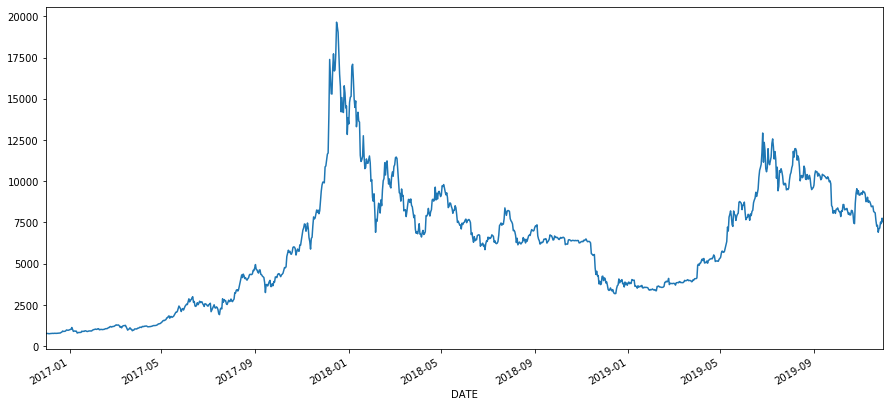

In [3]:
plt.figure(figsize(15,7))
btc.CLOSE.plot()

Проверка стационарности ряда:

Критерий Дики-Фуллера: p=0.181296


<Figure size 1080x720 with 0 Axes>

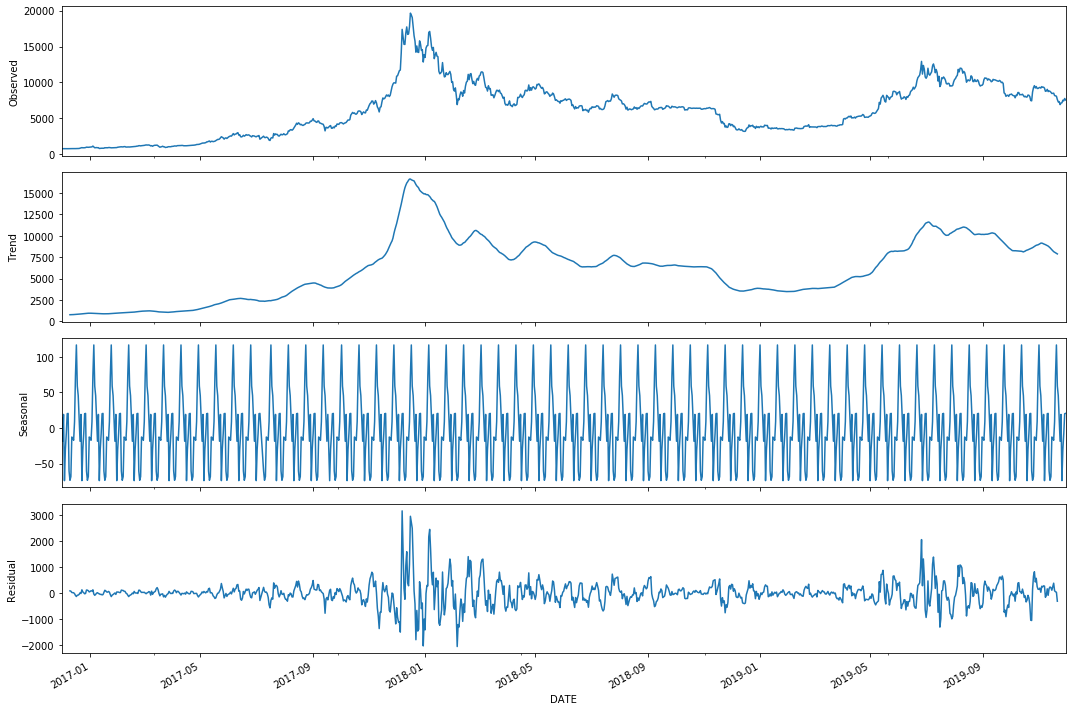

In [4]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(btc.CLOSE, freq=19).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(btc.CLOSE)[1])

### Стационарность

Критерий Дики-Фуллера не отвергает гипотезу нестационарности. Попробуем обычное дифференцирование; проверим стационарность полученного ряда:

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

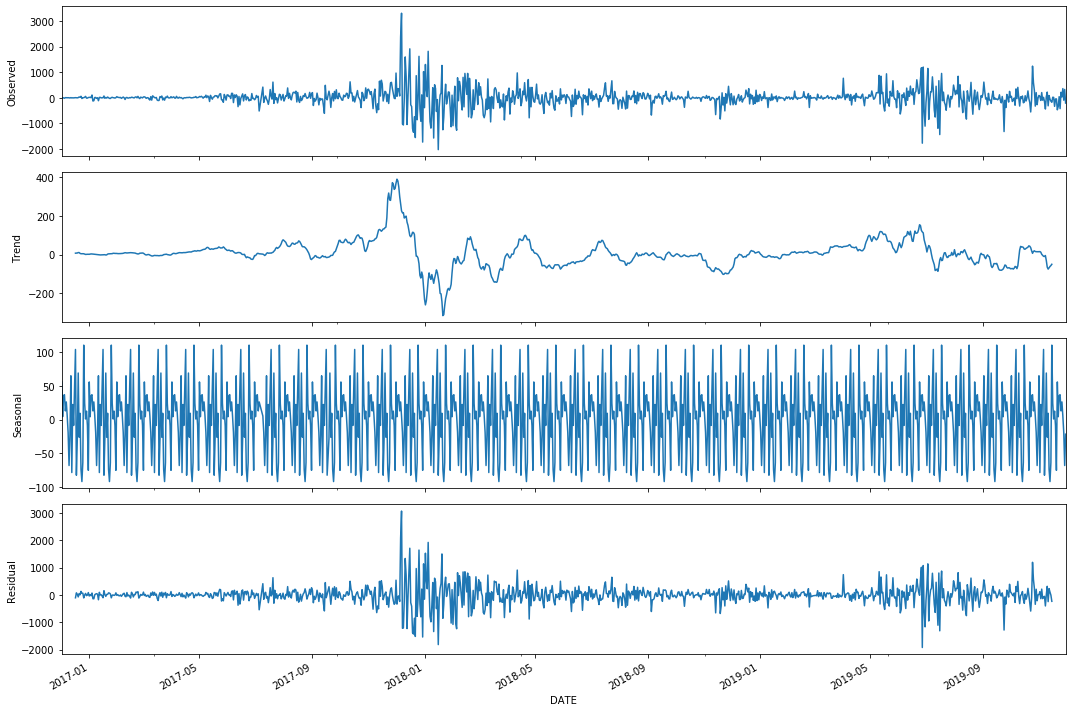

In [5]:
i=1
btc['CLOSE_diff'] = btc.CLOSE - btc.CLOSE.shift(i)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(btc.CLOSE_diff[i:], freq=30).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(btc.CLOSE_diff[i:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше, хоть и дисперсия остатков непостоянна во временени.

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

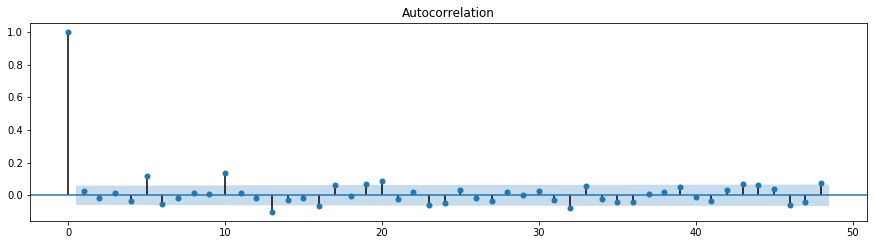

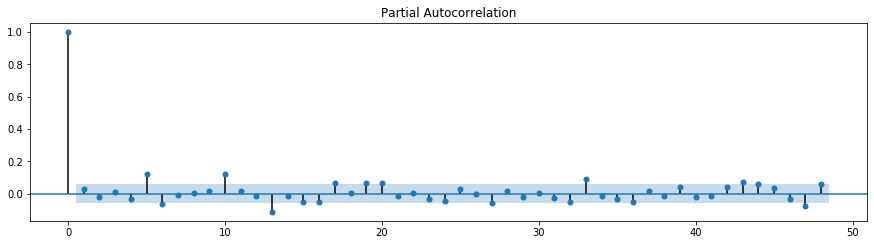

In [6]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(btc.CLOSE_diff[i+1:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(btc.CLOSE_diff[i+1:].values.squeeze(), lags=48, ax=ax)
pylab.show()

In [27]:
p = range(0, 6)
d=1
q = range(0, 6)

In [28]:
parameters = product(p, q)
parameters_list = list(parameters)
len(parameters_list)

36

In [15]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    if (param[0]==0 and param[1]==0):
        continue
    else:
        #try except нужен, потому что на некоторых наборах параметров модель не обучается
        try:
            model=sm.tsa.statespace.SARIMAX(btc.CLOSE, order=(param[0], d, param[1])
                                           ).fit(disp=-1)
        #выводим параметры, на которых модель не обучается и переходим к следующему набору
        except ValueError:
            print('wrong parameters:', param)
            continue
        aic = model.aic
        #сохраняем лучшую модель, aic, параметры
        if (aic < best_aic):
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 19.2 s


In [16]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

   parameters           aic
28     (4, 5)  15920.566843
27     (4, 4)  15923.722477
33     (5, 4)  15924.761680
34     (5, 5)  15930.759939
14     (2, 3)  15931.710471


Лучшая модель:

In [17]:
print(best_model.summary())

                           Statespace Model Results                           
Dep. Variable:                  CLOSE   No. Observations:                 1091
Model:               SARIMAX(4, 1, 5)   Log Likelihood               -7950.283
Date:                Tue, 17 Dec 2019   AIC                          15920.567
Time:                        19:59:50   BIC                          15970.506
Sample:                             0   HQIC                         15939.468
                               - 1091                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3922      0.061     -6.431      0.000      -0.512      -0.273
ar.L2          0.0188      0.035      0.534      0.593      -0.050       0.088
ar.L3         -0.5170      0.029    -17.948      0.0

Её остатки:

Критерий Стьюдента: p=0.591591
Критерий Дики-Фуллера: p=0.000000


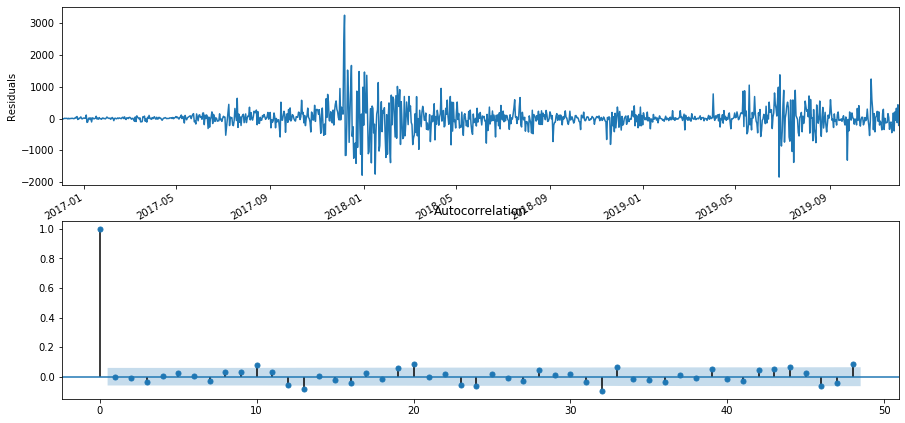

In [18]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[i+1:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[i+1:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[i+1:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[i+1:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) и частично-стационарны (подтверждается критерием Дики-Фуллера и визуально). Посмотрим, насколько хорошо модель описывает данные:

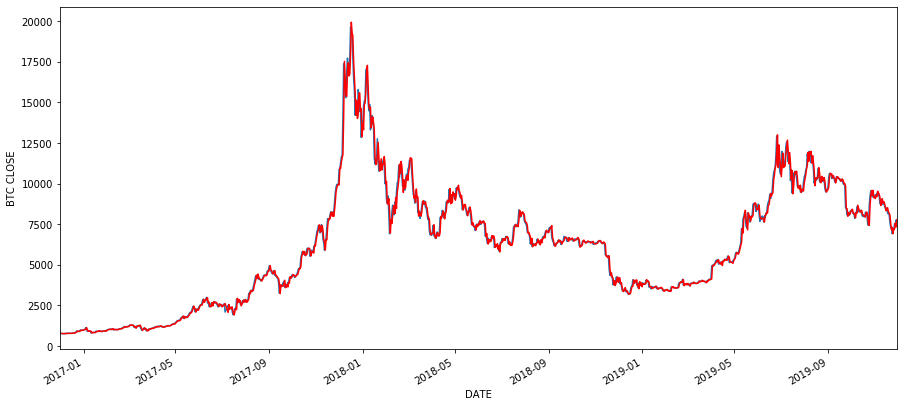

In [42]:
btc['model'] = best_model.fittedvalues
plt.figure(figsize(15,7))
btc.CLOSE.plot()
btc.model[i+1:].plot(color='r')
plt.ylabel('BTC CLOSE')
pylab.show()

In [31]:
def coef_determination(ii,real,estimate):
    SStot = 0
    SSres = 0
    for j in range(ii,len(real)):
        SSres+=(real[j]-estimate[j])**2
    for j in range(ii,len(real)):
        SStot+=(real[j]-np.mean(real))**2
    return(1-SSres/SStot)

Коэффициент детерминации достаточно высокий:

In [46]:
coef_determination(i+1,btc.CLOSE,btc.model)

0.9903621687419907

### Прогноз

In [56]:
kk=10
date_list = [datetime.datetime.strptime("2019-12-01", "%Y-%m-%d") + relativedelta(days=x) for x in range(0,kk)]
future = pd.DataFrame(index=date_list, columns= btc.columns)
btc_new = pd.concat([btc, future])

In [57]:
a=np.zeros(len(btc))
start=len(btc)+1
b=best_model.predict(start=start,end=start+kk-1)
c=np.concatenate((a, b))
btc_new['ARIMA_forecast'] = c
d=best_model.get_prediction(start=start,end=start+kk-1).conf_int()['lower CLOSE']
e=np.concatenate((a, d))
btc_new['ARIMA_lower_CLOSE'] = e
f=best_model.get_prediction(start=start,end=start+kk-1).conf_int()['upper CLOSE']
g=np.concatenate((a, f))
btc_new['ARIMA_upper_CLOSE'] = g
btc_test = pd.read_csv('BTC-USD_2.1.csv',';', index_col=['DATE'], parse_dates=['DATE'], dayfirst=True)
h=np.concatenate((a,btc_test['CLOSE']))
btc_new['real_values'] = h

C:\Users\nekit\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


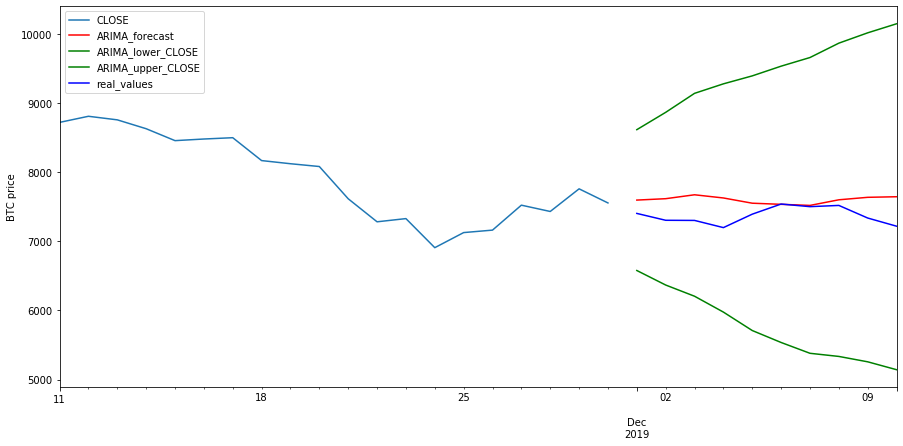

In [59]:
btc_new.CLOSE[len(btc)-20:].plot()
btc_new.ARIMA_forecast[len(btc):].plot(color='r')
btc_new.ARIMA_lower_CLOSE[len(btc):].plot(color='green')
btc_new.ARIMA_upper_CLOSE[len(btc):].plot(color='green')
btc_new.real_values[len(btc):].plot(color='blue')
plt.ylabel('BTC price')
plt.legend(loc='upper left')
pylab.show()

# ДТЗ. Часть 4

In [60]:
btc_new_2 = pd.read_csv('BTC-USD_2.2.csv',';', index_col=['DATE'], parse_dates=['DATE'], dayfirst=True)
l=np.concatenate((a,btc_new_2['GARCH_forecast']))
btc_new['GARCH_forecast'] = l
m=np.concatenate((a,btc_new_2['GARCH_lower_CLOSE']))
btc_new['GARCH_lower_CLOSE'] = m
n=np.concatenate((a,btc_new_2['GARCH_upper_CLOSE']))
btc_new['GARCH_upper_CLOSE'] = n

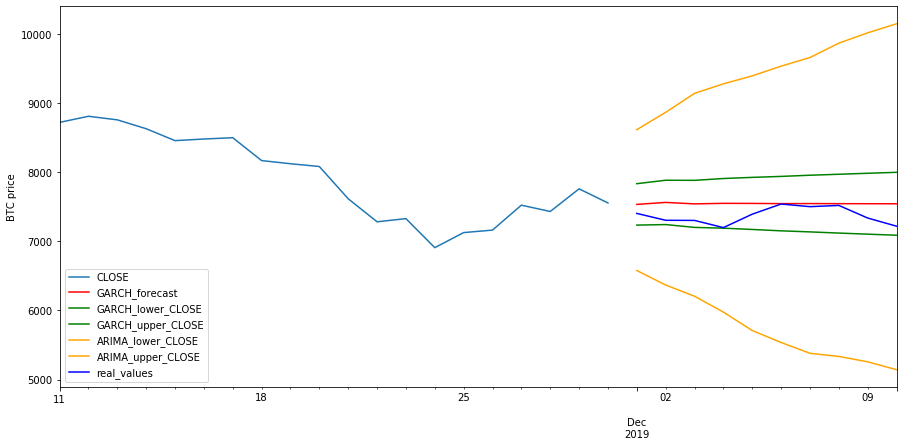

In [62]:
btc_new.CLOSE[len(btc)-20:].plot()
btc_new.GARCH_forecast[len(btc):].plot(color='r')
btc_new.GARCH_lower_CLOSE[len(btc):].plot(color='green')
btc_new.GARCH_upper_CLOSE[len(btc):].plot(color='green')
btc_new.ARIMA_lower_CLOSE[len(btc):].plot(color='orange')
btc_new.ARIMA_upper_CLOSE[len(btc):].plot(color='orange')
btc_new.real_values[len(btc):].plot(color='blue')
plt.legend()
plt.ylabel('BTC price')
pylab.show()